In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from bmtk.builder import NetworkBuilder
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)

In [2]:
v1_fraction = 0.01

v1_models = {
  "VisL4": {
    "depth_range": [310.0, 430.0],
    "models": [
      {
        "N": 2384,
        "model_name": "Sst_501282204",
        "cell_line": "i4Sst",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "501282204_glif_lif_asc_config.json"
      },
      {
        "N": 11898,
        "model_name": "Rorb_314642645",
        "cell_line": "e4Rorb",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "314642645_glif_lif_asc_config.json"
      },
      {
        "N": 13728,
        "model_name": "Scnn1a_517982558",
        "cell_line": "e4Scnn1a",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "517982558_glif_lif_asc_config.json"
      },
      {
        "N": 1231,
        "model_name": "Htr3a_474626527",
        "cell_line": "i4Htr3a",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "474626527_glif_lif_asc_config.json"
      },
      {
        "N": 14644,
        "model_name": "other_483018019",
        "cell_line": "e4other",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "483018019_glif_lif_asc_config.json"
      },
      {
        "N": 4461,
        "model_name": "Pvalb_478958894",
        "cell_line": "i4Pvalb",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "478958894_glif_lif_asc_config.json"
      }
    ]
  }
}

In [3]:
# models = json.load(open('v1_models.json', 'r'))

models_df = None
for layer, layer_dict in v1_models.items():
    tmp_df = pd.DataFrame.from_dict(
        layer_dict['models']
    )
    tmp_df['layer'] = layer
    tmp_df['N'] = (v1_fraction*tmp_df['N'].values).astype(int)
    models_df = layer_models_df if None else pd.concat((models_df, tmp_df), ignore_index=True)

print('Total Cells: {}'.format(models_df['N'].sum()))
    
models_df = models_df.sort_values(['layer', 'ei'])
models_df.set_index(['layer', 'ei', 'model_name'])

Total Cells: 480


N cell_line    model_type         model_template  \
layer ei model_name                                                             
VisL4 e  Rorb_314642645    118    e4Rorb  point_neuron  nest:glif_lif_asc_psc   
         Scnn1a_517982558  137  e4Scnn1a  point_neuron  nest:glif_lif_asc_psc   
         other_483018019   146   e4other  point_neuron  nest:glif_lif_asc_psc   
      i  Sst_501282204      23     i4Sst  point_neuron  nest:glif_lif_asc_psc   
         Htr3a_474626527    12   i4Htr3a  point_neuron  nest:glif_lif_asc_psc   
         Pvalb_478958894    44   i4Pvalb  point_neuron  nest:glif_lif_asc_psc   

                                              dynamics_params  
layer ei model_name                                            
VisL4 e  Rorb_314642645    314642645_glif_lif_asc_config.json  
         Scnn1a_517982558  517982558_glif_lif_asc_config.json  
         other_483018019   483018019_glif_lif_asc_config.json  
      i  Sst_501282204     501282204_glif_lif_asc_config.json  
         Htr3a_474626527   474626527_glif_lif_asc_config.json  
         Pvalb_478958894   478958894_glif_lif_asc_config.json

In [4]:
def generate_column_positions(n_cells, depth_range, radial_range):
    radius_outer = radial_range[1]
    radius_inner = radial_range[0]
    
    phi = 2.0 * np.pi * np.random.random(n_cells)
    r = np.sqrt((radius_outer**2 - radius_inner**2)*np.random.random(n_cells) + radius_inner**2)
    x = r * np.cos(phi)
    z = r * np.sin(phi)
    y = (depth_range[1] - depth_range[0]) * np.random.random(n_cells) + depth_range[0]
    return x, y, z


In [5]:
v1 = NetworkBuilder('v1')
radial_range = (1.0, 845.0)

for layer, layer_dict in v1_models.items():
    depth_range = layer_dict['depth_range']
    for model_props in layer_dict['models']:
        n_cells = int(model_props['N']*v1_fraction)
        x, y, z = generate_column_positions(n_cells, depth_range=depth_range, radial_range=radial_range)
        v1.add_nodes(
            N=n_cells,
            layer=layer,       
            x=x,
            y=y,
            z=z,
            tuning_angle=np.linspace(0.0, 360.0, n_cells),
            model_name=model_props['model_name'],
            cell_line=model_props['cell_line'],
            ei=model_props['ei'],
            model_type=model_props['model_type'],
            model_template=model_props['model_template'],
            dynamics_params=model_props['dynamics_params']
        )
        
v1.build()
v1.save(output_dir='network')

In [6]:
def positions_grids(n_cells, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    """Randomly generate x, y positions on a screen/rectangle of given "size" divided into evenly sized
    grids. The number of cells in each grid will be evenly distributed += 1 cell. But within each grid 
    the distribution of coordinates are randomized.
    """
    
    n_grids = x_grids*y_grids
    tile_width = size[0]/x_grids
    tile_height = size[1]/y_grids

    # Keeps track of the total number of cells in each grid evenly divided, if n_cells is not divisible
    #  by n_grids then randomly distribute the remaining cells into different grids
    grid_cell_counts = np.full(y_grids*x_grids, int(n_cells/n_grids))
    grid_remainder = n_cells % n_grids
    if grid_remainder != 0:
        rand_idxs = np.random.choice(range(len(grid_cell_counts)), size=grid_remainder, replace=False)
        grid_cell_counts[rand_idxs] += 1
    grid_cell_counts = grid_cell_counts.reshape((x_grids, y_grids))
    
    # for each grid generate random coordinates
    xs = np.zeros(n_cells)
    ys = np.zeros(n_cells)
    x_indx, y_indx = 0, 0
    for i in range(x_grids):
        for j in range(y_grids):
            n = grid_cell_counts[i, j]           
            xs[x_indx:(x_indx+n)] = np.random.uniform(i*tile_width, (i+1)*tile_width, n)
            ys[y_indx:(y_indx+n)] = np.random.uniform(j*tile_height, (j+1)*tile_height, n)
            x_indx += n
            y_indx += n
    
    return xs, ys


def plot_grids(lgn_net, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    lgn_df = pd.DataFrame({
        'model_name': [n['model_name'] for n in lgn_net.nodes()],
        'x': [n['x'] for n in lgn_net.nodes()],
        'y': [n['y'] for n in lgn_net.nodes()],
    })
    for model_name, model_df in lgn_df.groupby('model_name'):
        ax.scatter(model_df['x'].values, model_df['y'].values, s=10, label=model_name)
    
    ax.set_xticks(np.arange(0, size[0]+x_grids, size[0]/x_grids))
    ax.set_yticks(np.arange(0, size[1]+y_grids, size[1]/y_grids))
    ax.legend()
    ax.grid()


## Feedforward inputs from LGN


#### LGN cell models

In [7]:
x_grids, y_grids = 15, 10
field_size = (240.0, 120.0)
lgn_fraction = 1.0

lgn_models = {
  "sON_TF1": {
    "N": 1050,
    # "model_name": "sON_TF1",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF1",
    "dynamics_params": "sON_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF2": {
    "N": 750,
    # "model_name": "sON_TF2",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF2",
    "dynamics_params": "sON_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF4": {
    "N": 1050,
    # "model_name": "sON_TF4",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF4",
    "dynamics_params": "sON_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF8": {
    "N": 2250,
    # "model_name": "sON_TF8",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF8",
    "dynamics_params": "sON_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF1": {
    "N": 1200,
    # "model_name": "sOFF_TF1",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF1",
    "dynamics_params": "sOFF_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF2": {
    "N": 1200,
    # "model_name": "sOFF_TF2",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF2",
    "dynamics_params": "sOFF_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF4": {
    "N": 2250,
    # "model_name": "sOFF_TF4",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF4",
    "dynamics_params": "sOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF8": {
    "N": 1200,
    # "model_name": "sOFF_TF8",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF8",
    "dynamics_params": "sOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF15": {
    "N": 1050,
    # "model_name": "sOFF_TF15",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF15",
    "dynamics_params": "sOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF4": {
    "N": 1500,
    # "model_name": "tOFF_TF4",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF4",
    "dynamics_params": "tOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF8": {
    "N": 750,
    # "model_name": "tOFF_TF8",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF8",
    "dynamics_params": "tOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF15": {
    "N": 1200,
    # "model_name": "tOFF_TF15",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF15",
    "dynamics_params": "tOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sONsOFF_001": {
    "N": 1200,
    # "model_name": "sONsOFF_001",
    "subtype": "sONsOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONsOFF_001",
    "dynamics_params": "sOFF_TF4.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [6, 6],
    "sf_sep": 6.0,
    "tuning_angle": True
  },
  "sONtOFF_001": {
    "N": 750,
    # "model_name": "sONtOFF_001",
    "subtype": "sONtOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONtOFF_001",
    "dynamics_params": "tOFF_TF8.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [9, 9],
    "sf_sep": 4.0,
    "tuning_angle": True
  }
}

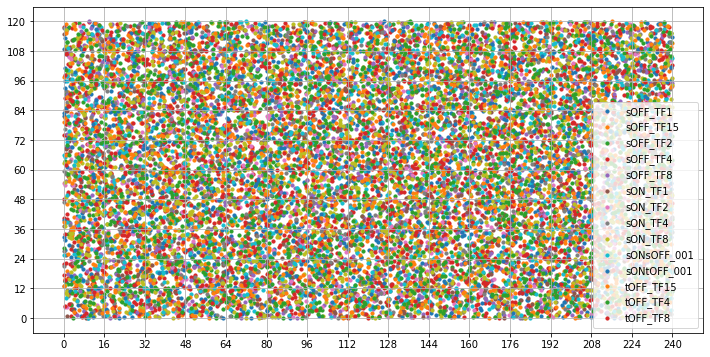

In [8]:
# lgn_models = json.load(open('lgn_models.json', 'r'))

lgn = NetworkBuilder('lgn')
for model_name, params in lgn_models.items():
    n_cells = int(params['N']*lgn_fraction)
    x, y = positions_grids(n_cells, x_grids=x_grids, y_grids=y_grids, size=field_size)
    size_range = params['size_range']
    lgn.add_nodes(
        N=params['N'],
        model_name=model_name,
        subtype=params['subtype'],
        model_type=params['model_type'],
        model_template=params['model_template'],
        dynamics_params=params['dynamics_params'],
        non_dom_params=params.get('non_dom_params', None),
        x=x,
        y=y,
        tuning_angle=[np.NaN]*n_cells if params['tuning_angle'] else np.linspace(0.0, 360.0, n_cells),
        spatial_size=np.random.uniform(size_range[0], size_range[1], n_cells),
        sf_sep=params.get('sf_sep', None),
        jitter_lower=0.975,
        jitter_upper=1.025
    )

plot_grids(lgn, x_grids=x_grids, y_grids=y_grids, size=field_size)

In [9]:
lgn_connections = {
  "e4Nr5a1": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5272113965417778,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4Rorb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.518666852825,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4Scnn1a": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5173743580285,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4other": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5152488843942,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Htr3a": {
    "connection_params": {
      "probability": 0.444,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 20
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Pvalb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 10.0,
      "ON_OFF_w_max": 13.0,
      "aspectRatio_min": 1.6,
      "aspectRatio_max": 1.8,
      "N_syn": 75
    },
    "edge_types_params": {
      "syn_weight": 1.7916764292750003,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Sst": {
    "connection_params": {
      "probability": 0.333,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 25
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  }
}

In [10]:
def get_selection_probability(src_type, lgn_models_subtypes_dictionary):
    current_model_subtypes = lgn_models_subtypes_dictionary[src_type[0:4]]['sub_types']
    current_model_probabilities = lgn_models_subtypes_dictionary[src_type[0:4]]['probabilities']
    lgn_model_idx = [i for i, model in enumerate(current_model_subtypes) if src_type == model][0]
    return current_model_probabilities[lgn_model_idx]


def select_lgn_sources(sources, target, lgn_mean, probability, poissonParameter, sON_ratio, centers_d_min,
                       centers_d_max, ON_OFF_w_min, ON_OFF_w_max, aspectRatio_min, aspectRatio_max, N_syn):
    source_ids = [s.node_id for s in sources]

    # Check if target supposed to get a connection and if not, then no need to keep calculating.
    if np.random.random() > probability:
        return [None]*len(source_ids)

    subfields_centers_distance_L = centers_d_max - centers_d_min
    subfields_ON_OFF_width_L = ON_OFF_w_max - ON_OFF_w_min
    subfields_width_aspect_ratio_L = aspectRatio_max - aspectRatio_min

    x_position_lin_degrees = np.tan(0.07*np.array(target['x'])*np.pi/180.0)*180.0/np.pi
    y_position_lin_degrees = np.tan(0.04*np.array(target['z'])*np.pi/180.0)*180.0/np.pi

    vis_x = lgn_mean[0] + ((x_position_lin_degrees))  # - l4_mean[0]) / l4_dim[0]) * lgn_dim[0]
    vis_y = lgn_mean[1] + ((y_position_lin_degrees))  # - l4_mean[2]) / l4_dim[2]) * lgn_dim[1]

    ellipse_center_x0 = vis_x  # tar_cells[tar_gid]['vis_x']
    ellipse_center_y0 = vis_y  # tar_cells[tar_gid]['vis_y']

    tuning_angle = float(target['tuning_angle'])
    tuning_angle = None if np.isnan(tuning_angle) else tuning_angle
    #tuning_angle = None if math.isnan(target['tuning_angle']) else target['tuning_angle']
    if tuning_angle is None:
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0) * subfields_ON_OFF_width_L) / 2.0  # Divide by 2 to convert from width to radius.
        ellipse_b0 = 2.5 * ellipse_b0  # 1.5 * ellipse_b0
        ellipse_a0 = ellipse_b0  # ellipse_b0
        top_N_src_cells_subfield = 15  # 20
        ellipses_centers_halfdistance = 0.0
        tuning_angle_value = 0.0
    else:
        tuning_angle_value = float(tuning_angle)
        ellipses_centers_halfdistance = (centers_d_min + np.random.uniform(0.0, 1.0)* subfields_centers_distance_L) / 2.0
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0) * subfields_ON_OFF_width_L) / 2.0  # Divide by 2 to convert from width to radius.
        ellipse_a0 = ellipse_b0 * (aspectRatio_min + np.random.uniform(0.0, 1.0) * subfields_width_aspect_ratio_L)
        ellipse_phi = tuning_angle_value + 180.0 + 90.0  # Angle, in degrees, describing the rotation of the canonical ellipse away from the x-axis.
        ellipse_cos_mphi = np.cos(-np.radians(ellipse_phi))
        ellipse_sin_mphi = np.sin(-np.radians(ellipse_phi))
        top_N_src_cells_subfield = 8  # 10 #9

        if np.random.random() < sON_ratio:
            cell_sustained_unit = 'sON_'
        else:
            cell_sustained_unit = 'sOFF_'

    cell_TF = np.random.poisson(poissonParameter)
    while cell_TF <= 0:
        cell_TF = np.random.poisson(poissonParameter)

    sON_subunits = np.array([1., 2., 4., 8.])
    sON_sum = np.sum(abs(cell_TF - sON_subunits))
    p_sON = (1 - abs(cell_TF - sON_subunits) / sON_sum) / (len(sON_subunits) - 1)

    sOFF_subunits = np.array([1., 2., 4., 8., 15.])
    sOFF_sum = np.sum(abs(cell_TF - sOFF_subunits))
    p_sOFF = (1 - abs(cell_TF - sOFF_subunits) / sOFF_sum) / (len(sOFF_subunits) - 1)

    tOFF_subunits = np.array([4., 8., 15.])
    tOFF_sum = np.sum(abs(cell_TF - tOFF_subunits))
    p_tOFF = (1 - abs(cell_TF - tOFF_subunits) / tOFF_sum) / (len(tOFF_subunits) - 1)

    # to match previous algorithm reorganize source cells by type
    cell_type_dict = {}
    for lgn_model in lgn_models:
        cell_type_dict[lgn_model] = [(src.node_id, src) for src in sources if src['model_name'] == lgn_model]


    lgn_models_subtypes_dictionary = {
        'sON_': {'sub_types': ['sON_TF1', 'sON_TF2', 'sON_TF4', 'sON_TF8'], 'probabilities': p_sON},
        'sOFF': {'sub_types': ['sOFF_TF1', 'sOFF_TF2', 'sOFF_TF4', 'sOFF_TF8', 'sOFF_TF15'], 'probabilities': p_sOFF},
        'tOFF': {'sub_types': ['tOFF_TF4', 'tOFF_TF8', 'tOFF_TF15'], 'probabilities': p_tOFF},
    }

    src_cells_selected = {}
    for src_type in cell_type_dict.keys():
        src_cells_selected[src_type] = []

        if tuning_angle is None:
            ellipse_center_x = ellipse_center_x0
            ellipse_center_y = ellipse_center_y0
            ellipse_a = ellipse_a0
            ellipse_b = ellipse_b0
        else:
            if ('tOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 + ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 + ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            elif ('sON_' in src_type[0:5] or 'sOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 - ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 - ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            else:
                # Make this a simple circle.
                ellipse_center_x = ellipse_center_x0
                ellipse_center_y = ellipse_center_y0
                # Make the region from which source cells are selected a bit smaller for the transient_ON_OFF cells,
                # since each source cell in this case produces both ON and OFF responses.
                ellipse_b = ellipses_centers_halfdistance/2.0 #0.01 #ellipses_centers_halfdistance + 1.0*ellipse_b0 #0.01 #0.5 * ellipse_b0 # 0.8 * ellipse_b0
                ellipse_a = ellipse_b0 #0.01 #ellipse_b0

        # Find those source cells of the appropriate type that have their visual space coordinates within the ellipse.
        for src_id, src_dict in cell_type_dict[src_type]:
            x, y = (src_dict['x'], src_dict['y'])
            x = x - ellipse_center_x
            y = y - ellipse_center_y

            x_new = x
            y_new = y
            if tuning_angle is not None:
                x_new = x * ellipse_cos_mphi - y * ellipse_sin_mphi
                y_new = x * ellipse_sin_mphi + y * ellipse_cos_mphi

            if ((x_new / ellipse_a) ** 2 + (y_new / ellipse_b) ** 2) <= 1.0:
                if tuning_angle is not None:
                    if src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001':
                        src_tuning_angle = float(src_dict['tuning_angle'])
                        delta_tuning = abs(abs(abs(180.0 - abs(tuning_angle_value - src_tuning_angle) % 360.0) - 90.0) - 90.0)
                        if delta_tuning < 15.0:
                            src_cells_selected[src_type].append(src_id)

                    # elif src_type in ['sONtOFF_001']:
                    #     src_cells_selected[src_type].append(src_id)

                    elif cell_sustained_unit in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                    elif 'tOFF_' in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                else:
                    if (src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001'):
                        src_cells_selected[src_type].append(src_id)
                    else:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

    select_cell_ids = [id for _, selected in src_cells_selected.items() for id in selected]
    return [N_syn if id in select_cell_ids else None for id in source_ids]


In [11]:
from datetime import datetime
from datetime import timedelta


for layer, layer_dict in v1_models.items():
    for model_props in layer_dict['models']:
        model_name = model_props['model_name']
        cell_line = model_props['cell_line']
        
        conn_props = lgn_connections[cell_line]['connection_params']
        conn_props['lgn_mean'] = (field_size[0]/2.0, field_size[1]/2.0)
        edge_props = lgn_connections[cell_line]['edge_types_params']
        lgn.add_edges(
            source=lgn.nodes(),
            target=v1.nodes(model_name=model_name),
            connection_rule=select_lgn_sources,
            connection_params=conn_props,
            iterator='all_to_one',
            **edge_props
        )

start_time = datetime.now()
lgn.build()
lgn.save(output_dir='network')
end_time = datetime.now()
print('build time:', timedelta(seconds=(end_time - start_time).total_seconds()))

build time: 0:00:40.417464


### Running the LGN Simulation

#### Gratings inputs

We will start with a moving grating running at a 90 degree angle at a rate of 4.0Hz, with a 500.0 milisecond grey-screen at the start. Update the ```config.simulation_filternet.90deg_4Hz.json``` in the inputs sections:

```json
  "inputs": {
    "gratings": {
      "input_type": "movie",
      "module": "graiting",
      "row_size": 120,
      "col_size": 240,
      "gray_screen_dur": 500.0,
      "cpd": 0.04,
      "temporal_f": 4.0,
      "contrast": 0.8,
      "theta": 90.0,
      "evaluation_options": {
        "downsample": 1,
        "separable": true
      }
    }
  },
```

We can generate gratings input to our lgn cells either through the command line, with access to MPI:

```bash
 $ mpirun -np <N> python run_filternet config.simulation_filternet.90deg_4Hz.json
```

or in the jupyter notebook:

In [12]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('config.simulation_filternet.90deg_4Hz.json')
config.build_env()

net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2022-04-17 13:14:04,676 [WARNING] Directory ./inputs already exists.


2022-04-17 13:14:04,677 [INFO] Created log file


INFO:FilterNetIOUtils:Created log file


2022-04-17 13:14:05,136 [INFO] Building cells.


INFO:FilterNetIOUtils:Building cells.


2022-04-17 13:24:35,720 [INFO] Evaluating rates.


INFO:FilterNetIOUtils:Evaluating rates.


2022-04-17 13:39:08,993 [INFO] Done.


INFO:FilterNetIOUtils:Done.


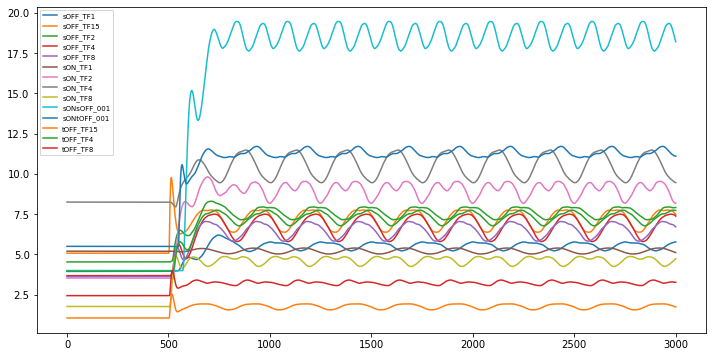

In [17]:
def plot_lgn_firing_rates():
    net = sonata.File(
        data_files='network/lgn_nodes.h5',
        data_type_files='network/lgn_node_types.csv'
    )
    lgn_nodes_df = net.nodes['lgn'].to_dataframe(index_by_id=False)
    lgn_nodes_df = lgn_nodes_df[['node_id', 'model_name']]

    rates_df = pd.read_csv('inputs/rates.gratings.90deg_4Hz.csv', sep=' ')
    rates_df = rates_df.merge(lgn_nodes_df, how='left', on='node_id')
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    for model_name, model_df in rates_df.groupby('model_name'):
        rates_tally = None
        n_counts = 0.0
        for _, node_grp in model_df.groupby('node_id'):
            n_counts += 1.0
            rates_tally = node_grp['firing_rates'].values if rates_tally is None else rates_tally + node_grp['firing_rates'].values

        rates_tally /= n_counts
        plt.plot(rates_tally, label=model_name)

    plt.legend(fontsize='x-small')
    plt.show()
    

plot_lgn_firing_rates()

## Running the L4 Simulation

In [14]:
from bmtk.simulator import pointnet


configure = pointnet.Config.from_json('config.simulation_pointnet.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Feb 16 2022 14:18:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2022-04-17 13:41:46,912 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-04-17 13:41:46,934 [INFO] Batch processing nodes for v1/0.


INFO:NestIOUtils:Batch processing nodes for v1/0.


2022-04-17 13:41:47,017 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2022-04-17 13:41:47,028 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-04-17 13:41:47,030 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-04-17 13:41:47,376 [INFO] Building recurrent connections


/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:NestIOUtils:Building recu

2022-04-17 13:41:47,377 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/kael/Workspace/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future ve

2022-04-17 13:42:00,140 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-04-17 13:42:00,149 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-04-17 13:42:03,463 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-04-17 13:42:03,509 [INFO] Done.


INFO:NestIOUtils:Done.


2.5


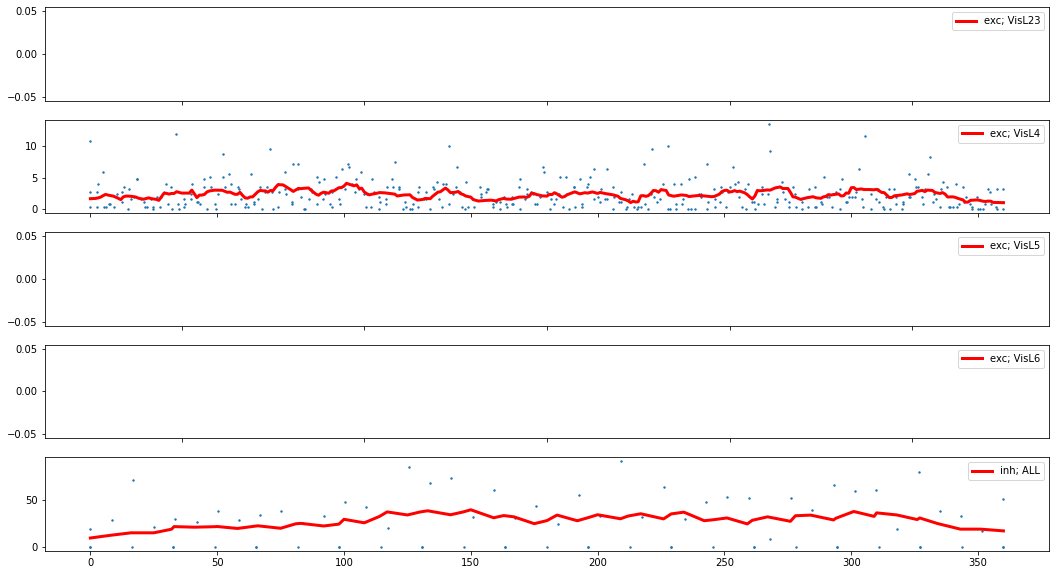

In [15]:
def plot_tunning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), convolv_window=10):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0
    print(dur_secs)

    net = sonata.File(
        data_files='network/v1_nodes.h5',
        data_type_files='network/v1_node_types.csv'
    )
    nodes_df = net.nodes['v1'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]

    spikes = SpikeTrains.load('output/spikes.h5')
    spikes_df = spikes.to_dataframe(population='v1')

    fr_df = spikes_df['node_ids'].value_counts().rename_axis('node_id').to_frame('spike_counts').reset_index()
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)
    fr_df['tuning_rounded'] = 0.0

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        # print(grp_df.index.values)
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if convolv_window and len(fr_avgs['firing_rates']) > convolv_window:
            filter = np.array([1.0] * int(convolv_window)) / float(convolv_window)
            fr_avgs['firing_rates'] = np.convolve(fr_avgs['firing_rates'].values, filter, mode='same')

        ax.plot(fr_avgs['firing_rates'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')

    # plot excitatory cells by layer
    fig, axes = plt.subplots(5, 1, figsize=(18, 10))
    for r, layer in enumerate(['VisL23', 'VisL4', 'VisL5', 'VisL6']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(5):
        if r != 4:
            axes[r].set_xticklabels([])

    plt.show()


plot_tunning_angle_fr('output/spikes.h5')